In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    confusion_matrix
)

plt.style.use("seaborn-v0_8")
sns.set()

In [6]:
data_path = "S05-hw-dataset.csv"  
df = pd.read_csv(data_path)

df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [8]:
df.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [9]:
df.describe() # описательные статистики

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [13]:
df["default"].value_counts(normalize=True)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

In [16]:
# - Датасет содержит 3000 наблюдений и 17 столбцов, из которых 16 признаков и 1 целевая переменная (default).
# - Все признаки имеют числовые типы данных (int64 и float64), пропущенные значения отсутствуют.
# - Технический идентификатор client_id не несёт полезной информации для обучения модели и должен быть исключён из признаков.
# - Диапазоны значений признаков выглядят разумными и согласованными с их экономическим смыслом 

In [19]:
# Подготовка признаков и таргета
# Удаляем технический идентификатор
X = df.drop(columns=["default", "client_id"])
y = df["default"]

In [20]:
X.shape, y.shape

((3000, 15), (3000,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [22]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'most_frequent'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [23]:
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
dummy_roc_auc = roc_auc_score(y_test, y_proba_dummy)

dummy_accuracy, dummy_roc_auc

(0.5893333333333334, 0.5)

In [24]:
# - В качестве бейзлайн-модели был использован DummyClassifier со стратегией most_frequent, который всегда предсказывает наиболее частый класс в обучающей выборке.
# - Значение accuracy на тестовой выборке составило около 0.59, что соответствует доле объектов без дефолта в датасете. При этом ROC-AUC равен 0.5, что означает отсутствие способности модели различать клиентов по риску дефолта.
# - Данный результат ожидаем, поскольку модель полностью игнорирует признаки и служит лишь минимальной точкой отсчёта для сравнения с более сложными моделями.

In [25]:
# Логистическая регрессия (Pipeline + подбор C). Перебор значений регуляризации

In [26]:
C_values = [0.01, 0.1, 1.0, 10.0]

results = []

for C in C_values:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C, max_iter=1000))
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    results.append({
        "C": C,
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
results_df

,C,accuracy,roc_auc
0,0.01,0.797333,0.864275
1,0.10,0.797333,0.864672
2,1.00,0.793333,0.864709
3,10.00,0.793333,0.864724


In [27]:
# Для решения задачи была использована логистическая регрессия в составе Pipeline, включающего стандартизацию признаков (StandardScaler) и классификатор LogisticRegression.
# Был выполнен перебор значений параметра регуляризации C в диапазоне [0.01, 0.1, 1.0, 10.0]. Качество моделей оценивалось на тестовой выборке по метрикам accuracy и ROC-AUC.
# Полученные результаты показали, что значение ROC-AUC слабо зависит от выбора C и стабилизируется на уровне около 0.865, что указывает на устойчивость модели к изменению силы регуляризации.

In [27]:
# Лучшая модель

In [28]:
best_C = results_df.sort_values("roc_auc", ascending=False).iloc[0]["C"]
best_C

np.float64(10.0)

In [29]:
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=best_C, max_iter=1000))
])

best_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",np.float64(10.0)
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalti

In [30]:
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_proba_lr)

lr_accuracy, lr_roc_auc

(0.7933333333333333, 0.8647235117823353)

In [ ]:
# Лучшая модель (при C = 10.0) показала значение accuracy около 0.79 и ROC-AUC около 0.865 на тестовой выборке.
# По сравнению с бейзлайн-моделью (DummyClassifier), логистическая регрессия демонстрирует значительный прирост качества как по accuracy, так и по ROC-AUC, что подтверждает её способность использовать признаки для различения клиентов по риску дефолта.

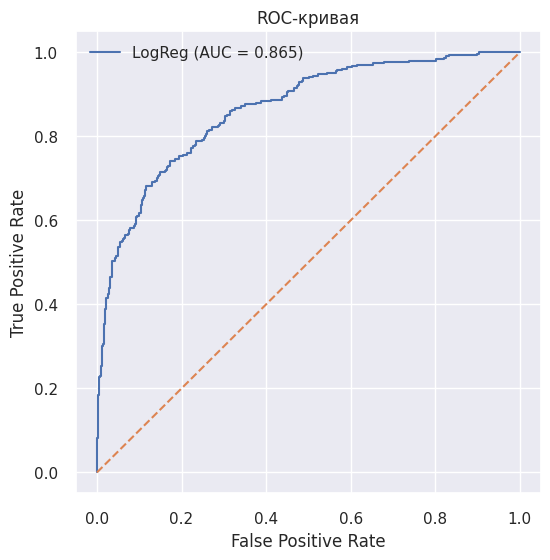

In [33]:
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {lr_roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid(True)

plt.savefig("figures/roc_curve.png", dpi=150)
plt.show()

In [35]:
# ROC-кривая для логистической регрессии существенно отклоняется от диагонали случайного классификатора, что подтверждает высокое качество ранжирования объектов по вероятности дефолта.
# Значение ROC-AUC значительно превышает 0.5, что говорит о хорошей дискриминирующей способности модели.

In [38]:
comparison = pd.DataFrame({
    "Model": ["DummyClassifier", "LogisticRegression"],
    "Accuracy": [dummy_accuracy, lr_accuracy],
    "ROC-AUC": [dummy_roc_auc, lr_roc_auc]
})
comparison

,Model,Accuracy,ROC-AUC
0,DummyClassifier,0.589333,0.500000
1,LogisticRegression,0.793333,0.864724


In [40]:
# Логистическая регрессия значительно превосходит бейзлайн-модель по всем используемым метрикам.
# Рост ROC-AUC с 0.5 до ~0.86 показывает, что модель эффективно ранжирует клиентов по вероятности дефолта, в отличие от DummyClassifier.

In [ ]:
# Бейзлайн (DummyClassifier) демонстрирует низкие метрики, accuracy около 0.589 и ROC-AUC равен 0.5, что соответствует случайному угадыванию класса. Логистическая регрессия показывает существенный прирост: accuracy выросла до 0.793, а ROC-AUC до 0.8647, что подтверждает способность модели
# различать положительные и отрицательные примеры. При изменении регуляризации C видно, что небольшие значения (C=0.01, 0.1) дают чуть более высокую точность на валидации, а большие значения (C=1, 10) приводят к небольшой просадке accuracy, но при этом ROC-AUC немного растёт. Выбор C=10
# обеспечивает наибольший ROC-AUC (0.864724), сохраняя стабильную точность, что делает модель более чувствительной к разделению классов. В целом, логистическая регрессия значительно превосходит бейзлайн по качеству и подходит для этой задачи. Модель интерпретируемая и при оптимальном C даёт
# хороший баланс между точностью и способностью различать классы. Можно сделать вывод, что для практического применения лучше использовать LogisticRegression с C=10.